<a href="https://colab.research.google.com/github/eyaler/workshop/blob/master/output/nn_4_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. Convolutional Neural Networks

In [1]:
%tensorflow_version 1.x
!pip install keras==2.2.5
!pip install livelossplot
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras import Input, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist, cifar10
from keras.utils import to_categorical
from livelossplot import PlotLossesKeras
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
!nvidia-smi -L

TensorFlow 1.x selected.


Using TensorFlow backend.


GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-31c4a679-7483-29a0-13ba-a2ceb5852b88)


In [2]:
# set random seeds for more reproducible results
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(43)

In [3]:
# load dataset
#(raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = mnist.load_data()
(raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = cifar10.load_data()
print(raw_x_train.shape, raw_y_train.shape)
gray = False
if len(raw_x_train.shape)==4 and gray:
    raw_x_train = np.mean(raw_x_train, axis=-1, keepdims=True)
    raw_x_test = np.mean(raw_x_test, axis=-1, keepdims=True)
if len(raw_x_train.shape)==3:
    raw_x_train = np.expand_dims(raw_x_train, axis=-1)
    raw_x_test = np.expand_dims(raw_x_test, axis=-1)
train_size = len(raw_y_train)
test_size = len(raw_y_test)
xdim = raw_x_train.shape[1]
ydim = raw_x_train.shape[2]
cdim = raw_x_train.shape[3]
print(raw_x_train.dtype, raw_y_train.dtype)

(50000, 32, 32, 3) (50000, 1)
uint8 uint8


[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
[6]


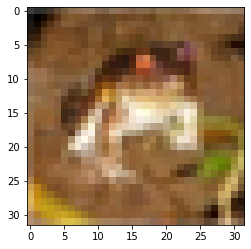

In [4]:
print(raw_x_train[0])
print(raw_y_train[0])
if gray:
    plt.imshow(raw_x_train[0][..., 0], cmap='gray')
else:
    plt.imshow(raw_x_train[0])

In [5]:
print(np.min(raw_x_train), np.max(raw_x_train), np.median(raw_x_train))
print(np.unique(raw_y_train, return_counts=True))
print(np.unique(raw_y_test, return_counts=True))

0 255 117.0
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))


In [6]:
n_classes = len(np.unique(raw_y_test))
x_train, y_train = shuffle(raw_x_train, raw_y_train, random_state=44)
x_train = x_train/255
x_test = raw_x_test/255
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(raw_y_test, n_classes)
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

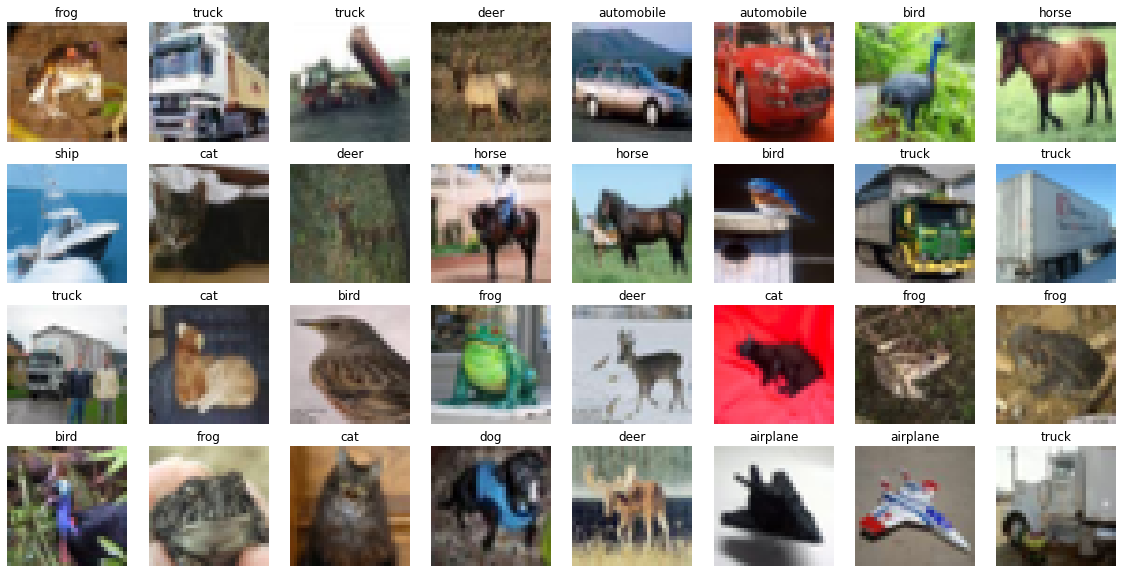

In [7]:
from mpl_toolkits.axes_grid1 import ImageGrid

#helper function to plot in grids
def show_grid(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(label_list[i])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

show_grid(raw_x_train[:32],4,8,label_list=[class_names[i] for i in np.squeeze(raw_y_train[:32])],show_labels=True,figsize=(20,10))

In [8]:
def get_model(bn):
    inputs = Input(shape=(xdim, ydim, cdim))
    f = Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
    if bn:
        f = BatchNormalization()(f)
    f = Conv2D(filters=32, kernel_size=3, activation='relu')(f)
    if bn:
        f = BatchNormalization()(f)
    f = MaxPooling2D()(f)
    f = Dropout(0.25)(f)
    f = Conv2D(filters=64, kernel_size=3, activation='relu')(f)
    if bn:
        f = BatchNormalization()(f)
    f = Conv2D(filters=64, kernel_size=3, activation='relu')(f)
    if bn:
        f = BatchNormalization()(f)
    f = MaxPooling2D()(f)
    f = Dropout(0.25)(f)
    f = Flatten()(f)
    f = Dense(512, activation='relu')(f)
    f = Dropout(0.5)(f)
    outputs = Dense(n_classes, activation='softmax')(f)
    return Model(inputs=inputs, outputs=outputs)

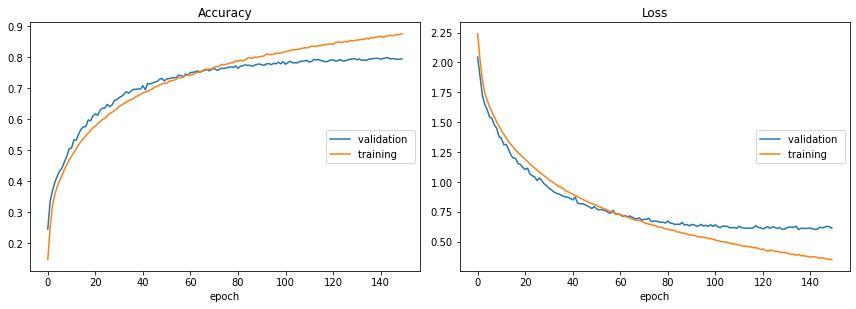

Accuracy
	validation       	 (min:    0.246, max:    0.798, cur:    0.794)
	training         	 (min:    0.148, max:    0.875, cur:    0.875)
Loss
	validation       	 (min:    0.600, max:    2.045, cur:    0.612)
	training         	 (min:    0.349, max:    2.240, cur:    0.349)


In [9]:
model = get_model(bn=False)
print(model.summary())
print((3*3*3+1)*32+(3*3*32+1)*32+(3*3*32+1)*64+(3*3*64+1)*64+((((32-2-2)/2-2-2)/2)**2*64+1)*512+(512+1)*10)
print('https://fomoro.com/tools/receptive-fields/#3,1,1,VALID;3,1,1,VALID;2,2,1,VALID;3,1,1,VALID;3,1,1,VALID;2,2,1,VALID')
print(3+2+1+2*(2+2+1))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=150, validation_split=0.2, callbacks=[PlotLossesKeras()])

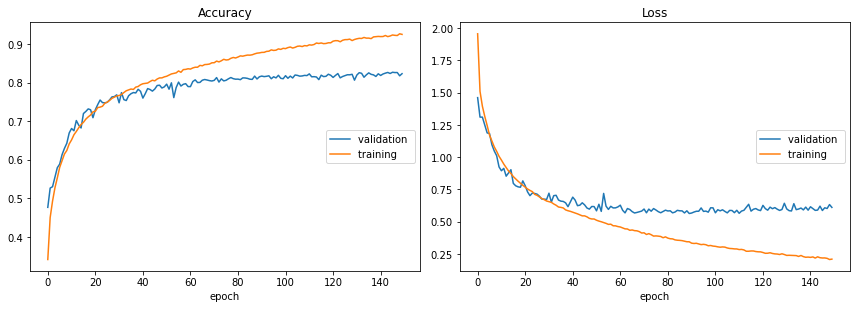

Accuracy
	validation       	 (min:    0.477, max:    0.827, cur:    0.823)
	training         	 (min:    0.341, max:    0.927, cur:    0.925)
Loss
	validation       	 (min:    0.563, max:    1.462, cur:    0.610)
	training         	 (min:    0.206, max:    1.957, cur:    0.209)


In [10]:
model = get_model(bn=True)
print(model.summary())
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=150, validation_split=0.2, callbacks=[PlotLossesKeras()])

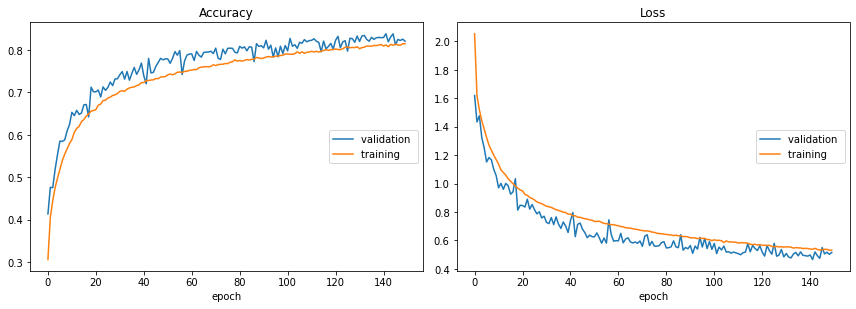

Accuracy
	validation       	 (min:    0.414, max:    0.838, cur:    0.821)
	training         	 (min:    0.306, max:    0.815, cur:    0.815)
Loss
	validation       	 (min:    0.466, max:    1.620, cur:    0.516)
	training         	 (min:    0.532, max:    2.054, cur:    0.532)


In [12]:
model = get_model(bn=True)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1)

valid_idx = int(train_size*0.8)
aug_train_data = datagen.flow(x=x_train[:valid_idx], y=y_train[:valid_idx], batch_size=64, seed=45)
valid_data = (x_train[valid_idx:], y_train[valid_idx:])
history = model.fit_generator(aug_train_data, epochs=150, steps_per_epoch=valid_idx // 64, validation_data=valid_data, callbacks=[PlotLossesKeras()])

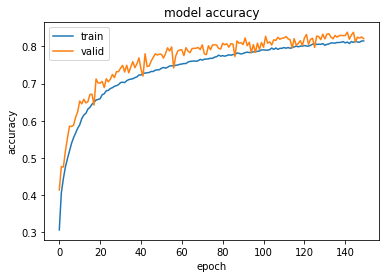

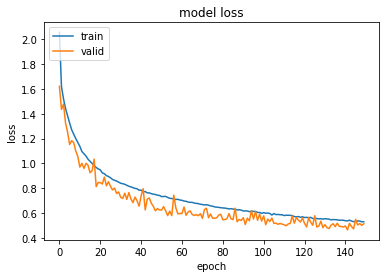

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix
loss, acc = model.evaluate(x=x_test, y=y_test)
print(loss, acc)
targets = np.argmax(y_test, axis=-1)
probabilities = model.predict(x=x_test)
predictions = np.argmax(probabilities, axis=-1)
cm = confusion_matrix(y_true=targets, y_pred=predictions)
print(cm)

10000/10000 [==============================] - 1s 91us/step
0.535426078748703 0.8201
[[853  19  22   9  14   1  19   9  29  25]
 [  5 953   0   0   1   0   2   1   5  33]
 [ 53   2 657  31  59  35 134  21   2   6]
 [ 16   5  35 610  49 102 130  27  11  15]
 [  7   1  24  14 810   8 103  29   3   1]
 [  8   4  15 108  45 708  69  36   1   6]
 [  5   0   4  16   4   3 961   4   3   0]
 [  6   3  10  17  45  25  27 859   0   8]
 [ 47  25   9   6   2   1  13   1 879  17]
 [ 10  54   5   1   0   1   9   1   8 911]]


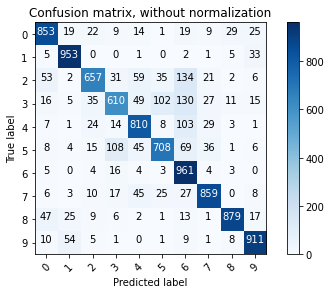

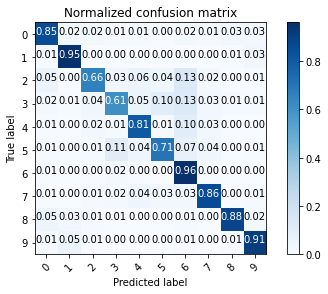

In [15]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    np.set_printoptions(precision=2)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

classes = np.arange(n_classes)
plot_confusion_matrix(cm, classes=classes)
plot_confusion_matrix(cm, classes=classes, normalize=True)

In [16]:
from sklearn.metrics import classification_report
report = classification_report(y_true=targets, y_pred=predictions, labels=classes, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.84      0.85      0.85      1000
  automobile       0.89      0.95      0.92      1000
        bird       0.84      0.66      0.74      1000
         cat       0.75      0.61      0.67      1000
        deer       0.79      0.81      0.80      1000
         dog       0.80      0.71      0.75      1000
        frog       0.66      0.96      0.78      1000
       horse       0.87      0.86      0.86      1000
        ship       0.93      0.88      0.91      1000
       truck       0.89      0.91      0.90      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



In [17]:
# top errors
from sklearn.metrics import log_loss
max_probs = np.max(probabilities, axis=-1)
losses = [log_loss(y_true=y, y_pred=prob, eps=1e-7) for y,prob in zip(y_test,probabilities)]
print('loss\tindex\ttrue\tpredicted\tprobability')
top_errors = sorted(list(zip(losses, np.arange(test_size), [class_names[i] for i in targets], [class_names[i] for i in predictions], max_probs)), reverse=True)[:32]
titles = []
inds = []
for i,error in enumerate(top_errors):
    titles.append('%s -> %s'%(error[2],error[3]))
    inds.append(error[1])
    if i<10:
        print('%.04f\t%d\t%s\t%s\t\t%.04f'%error)
    #plt.figure()
    #if gray:
    #    plt.imshow(x_test[error[1]][..., 0], cmap='gray')
    #else:
    #    plt.imshow(x_test[error[1]])

loss	index	true	predicted	probability
2.4990	2405	cat	frog		1.0000
1.5288	4924	horse	frog		0.9952
1.4217	4210	cat	truck		0.9897
1.4167	5548	ship	airplane		0.8850
1.3709	4106	cat	airplane		0.7873
1.3677	1732	truck	automobile		0.9989
1.3447	2226	bird	frog		0.9982
1.3370	779	dog	frog		0.9979
1.3309	2000	automobile	frog		0.9987
1.3113	1265	truck	automobile		0.9986


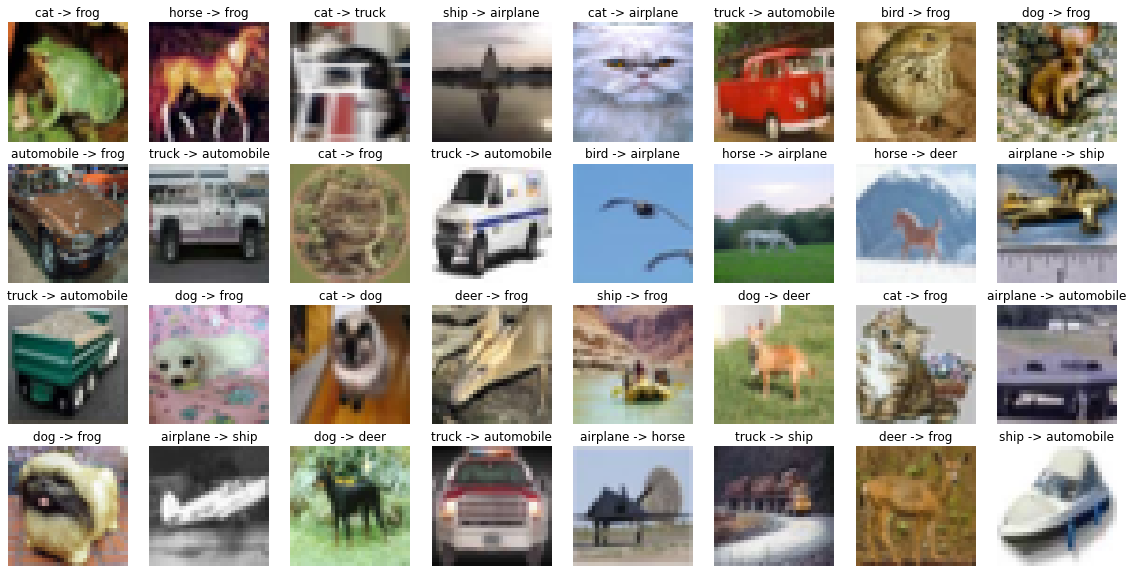

In [18]:
show_grid(raw_x_test[inds[:32]],4,8,label_list=titles[:32],show_labels=True,figsize=(20,10))